**Цель микросервиса:** сгенерировать решение математической задачи по условию

# Installing

In [4]:
!pip install -q -U datasets transformers sentence_transformers faiss-gpu accelerate peft trl bitsandbytes wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00


In [5]:
from google.colab import userdata


hf_token = userdata.get('hf_token')

In [18]:
from datasets import load_dataset
import warnings

warnings.filterwarnings('ignore')


dataset = load_dataset("foldl/MathSet")
dataset_pd = dataset["train"].to_pandas()
print(f'''shape --> {dataset_pd.shape}''')

shape --> (1127, 3)


In [6]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    AutoTokenizer,
    TrainingArguments,
    pipeline,
)
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training
from trl import SFTTrainer

In [7]:
# Model
base_model = "NousResearch/Llama-2-7b-hf"
new_model = "llama-2-7b-miniplatypus"

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, use_fast=True)
tokenizer.pad_token = tokenizer.unk_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [9]:
# Quantization configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

# LoRA configuration
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']
)

# Load base moodel
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map={"": 0}
)

# Cast the layernorm in fp32, make output embedding layer require grads, add the upcasting of the lmhead to fp32
model = prepare_model_for_kbit_training(model)

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

# Prepare dataset

In [19]:
dataset_pd.head(4)

,Q,S,A
0,В обменном пункте 1 гривна стоит 3 рубля 70 ко...,За 3 кг помидоров отдыхающие заплатили 4 · 3 ...,Ответ: 44
1,По тарифному плану «Просто как день» компания ...,"Заметим, что $ дробь: числитель: 700, знаменат...",Ответ: 43
2,На одну порцию рисовой каши требуется 40 грамм...,Из девятисот грамм риса можно приготовить $ др...,Ответ: 22
3,Ананасы стоят 85 руб. за штуку. Какое максимал...,"После снижения цены на 0,2 · 85 = 17 руб., ц...",Ответ: 7


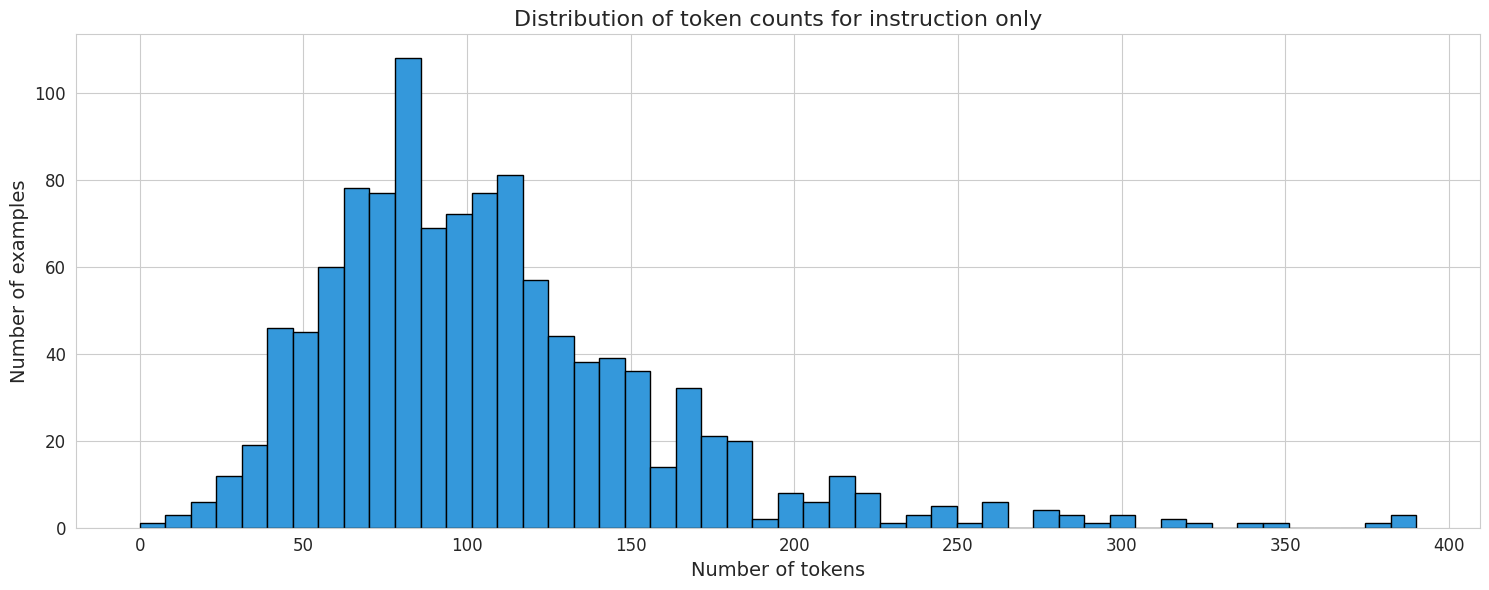

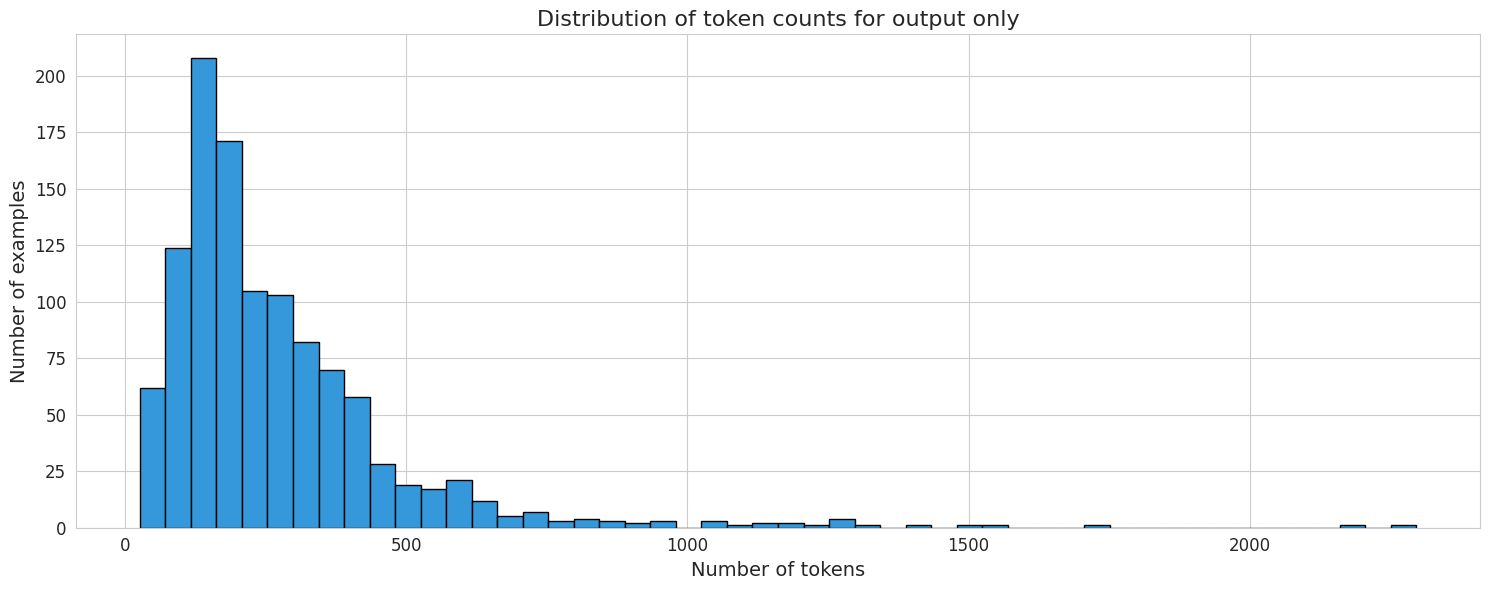

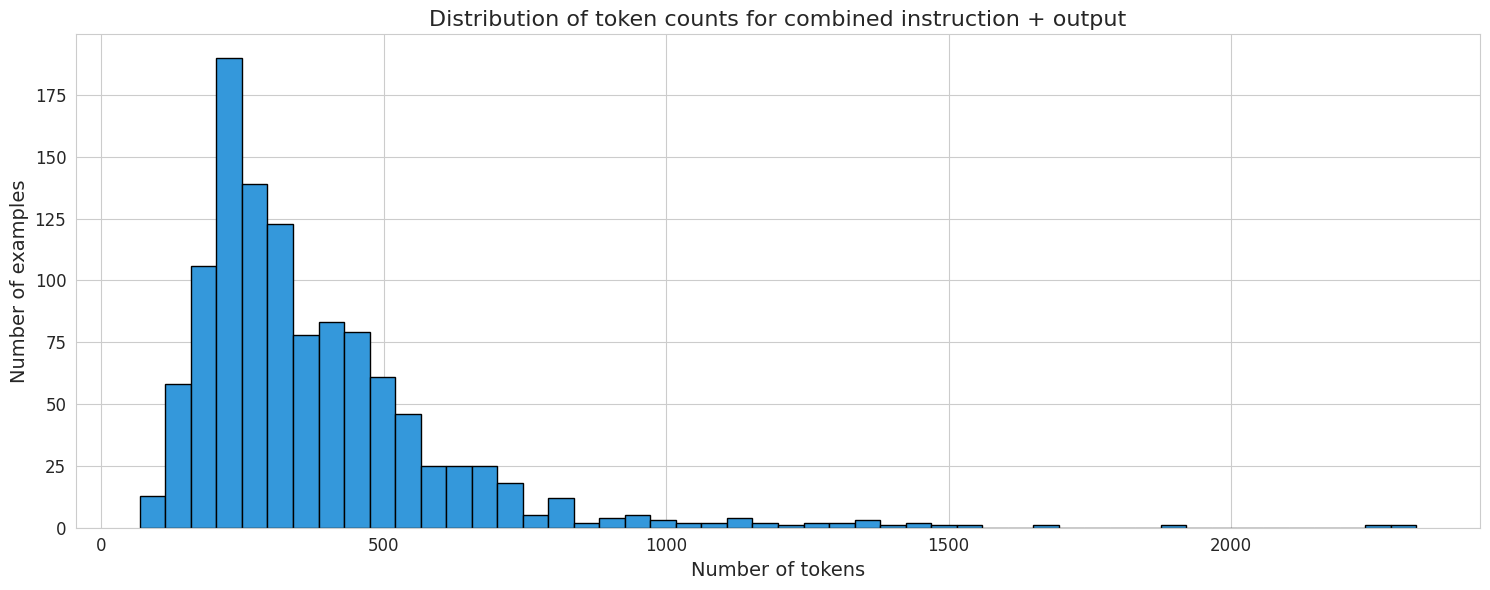

In [20]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")

# 2. Tokenize each row and count the number of tokens
instruction_token_counts = [len(tokenizer.tokenize(example)) for example in dataset['train']['Q']]
output_token_counts = [len(tokenizer.tokenize(example)) for example in dataset['train']['S']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Helper function to plot the distributions
def plot_distribution(token_counts, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

Number of valid rows: 1125
Removing 2 rows...


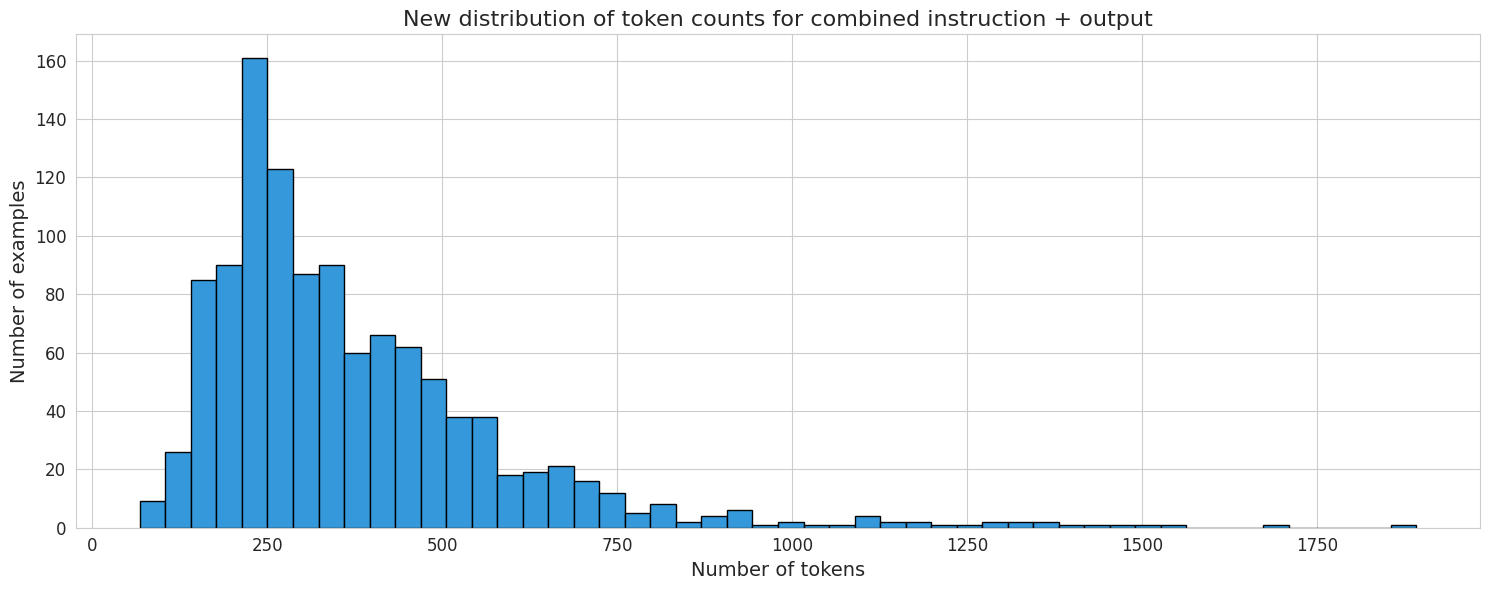

In [21]:
# Filter out rows with more than 2048 tokens
valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= 2048]
print(f"Number of valid rows: {len(valid_indices)}")
print(f"Removing {len(dataset['train']) - len(valid_indices)} rows...")

# Extract valid rows based on indices
dataset['train'] = dataset['train'].select(valid_indices)

# Get token counts for valid rows
token_counts = [combined_token_counts[i] for i in valid_indices]

plot_distribution(token_counts, "New distribution of token counts for combined instruction + output")

In [22]:
from sentence_transformers import SentenceTransformer
import faiss
from datasets import Dataset, DatasetDict
from tqdm.autonotebook import tqdm
import numpy as np

def deduplicate_dataset(dataset: Dataset, model: str, threshold: float):
    sentence_model = SentenceTransformer(model)
    outputs = [example["S"] for example in dataset['train']]

    print("Converting text to embeddings...")
    embeddings = sentence_model.encode(outputs, show_progress_bar=True)
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    index.add(normalized_embeddings)

    print("Filtering out near-duplicates...")
    D, I = index.search(normalized_embeddings, k=2)
    to_keep = []

    for i in tqdm(range(len(embeddings)), desc="Filtering"):
        # If the second closest vector (D[i, 1]) has cosine similarity above the threshold
        if D[i, 1] >= threshold:
            # Check if either the current item or its nearest neighbor is already in the to_keep list
            nearest_neighbor = I[i, 1]
            if i not in to_keep and nearest_neighbor not in to_keep:
                # If not, add the current item to the list
                to_keep.append(i)
        else:
            # If the similarity is below the threshold, always keep the current item
            to_keep.append(i)

    dataset = dataset['train'].select(to_keep)
    return DatasetDict({"train": dataset})

deduped_dataset = deduplicate_dataset(dataset, "thenlper/gte-large", 0.95)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Converting text to embeddings...


Batches:   0%|          | 0/36 [00:00<?, ?it/s]

Filtering out near-duplicates...


Filtering:   0%|          | 0/1125 [00:00<?, ?it/s]

In [23]:
print(f"Number of samples in the original dataset: {len(dataset['train'])}")
print(f"Number of samples in the deduped dataset: {len(deduped_dataset['train'])}")
print(f"Number of samples that were removed: {len(dataset['train']) - len(deduped_dataset['train'])}")

Number of samples in the original dataset: 1125
Number of samples in the deduped dataset: 766
Number of samples that were removed: 359


In [25]:
# Get the top k rows with the most tokens
def get_top_k_rows(dataset, token_counts, k):
    # Sort by descending token count and get top k indices
    sorted_indices = sorted(range(len(token_counts)), key=lambda i: token_counts[i], reverse=True)
    top_k_indices = sorted_indices[:k]

    # Extract top k rows
    top_k_data = {
        "Q": [dataset['train'][i]["Q"] for i in top_k_indices],
        "S": [dataset['train'][i]["S"] for i in top_k_indices]
    }

    return Dataset.from_dict(top_k_data)

# Get token counts
instruction_token_counts = [len(tokenizer.tokenize(example["Q"])) for example in deduped_dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["S"])) for example in deduped_dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

k = 1000  # You can adjust this value as needed
top_k_dataset = get_top_k_rows(deduped_dataset, combined_token_counts, k)

# Save these rows in a Dataset object with a 'train' split
dataset = DatasetDict({"train": top_k_dataset})

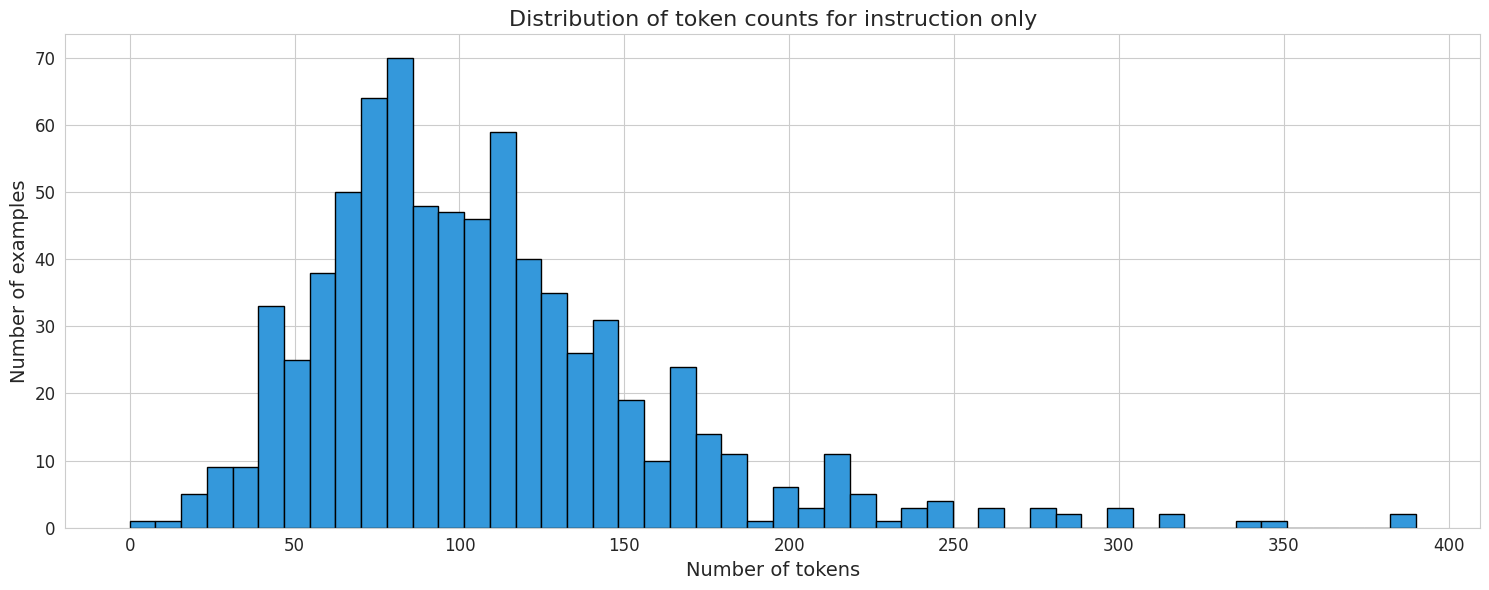

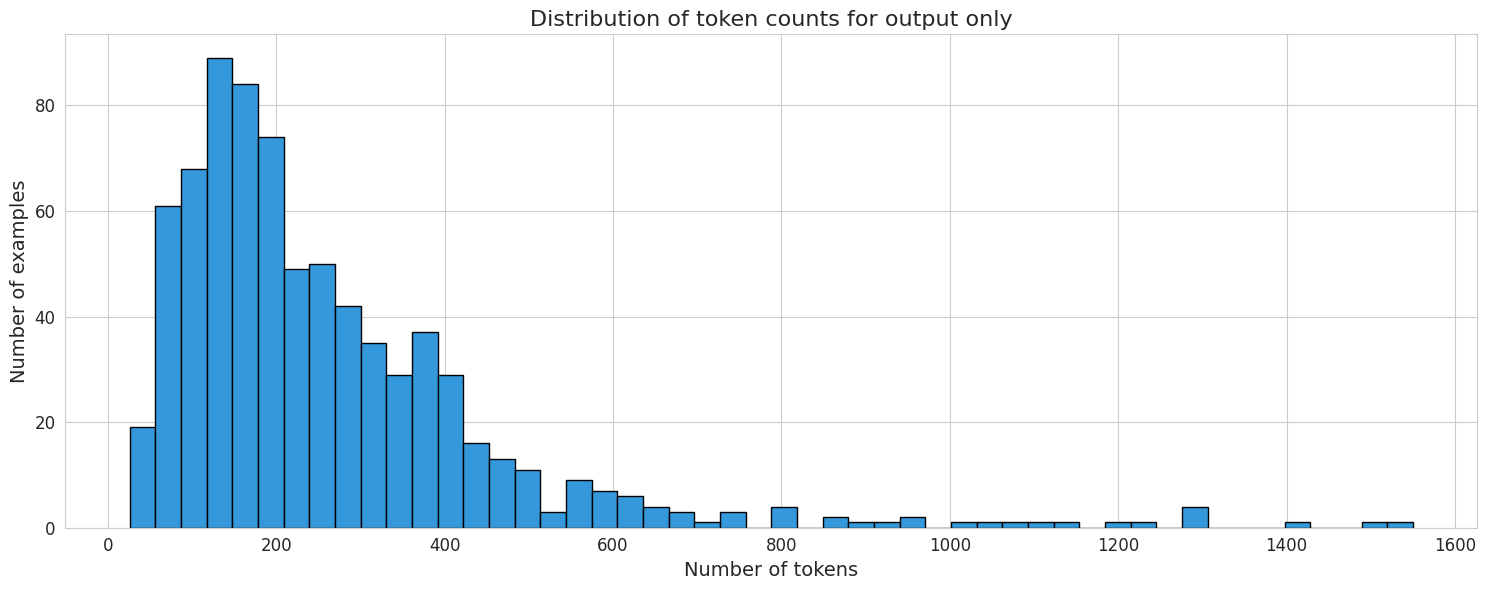

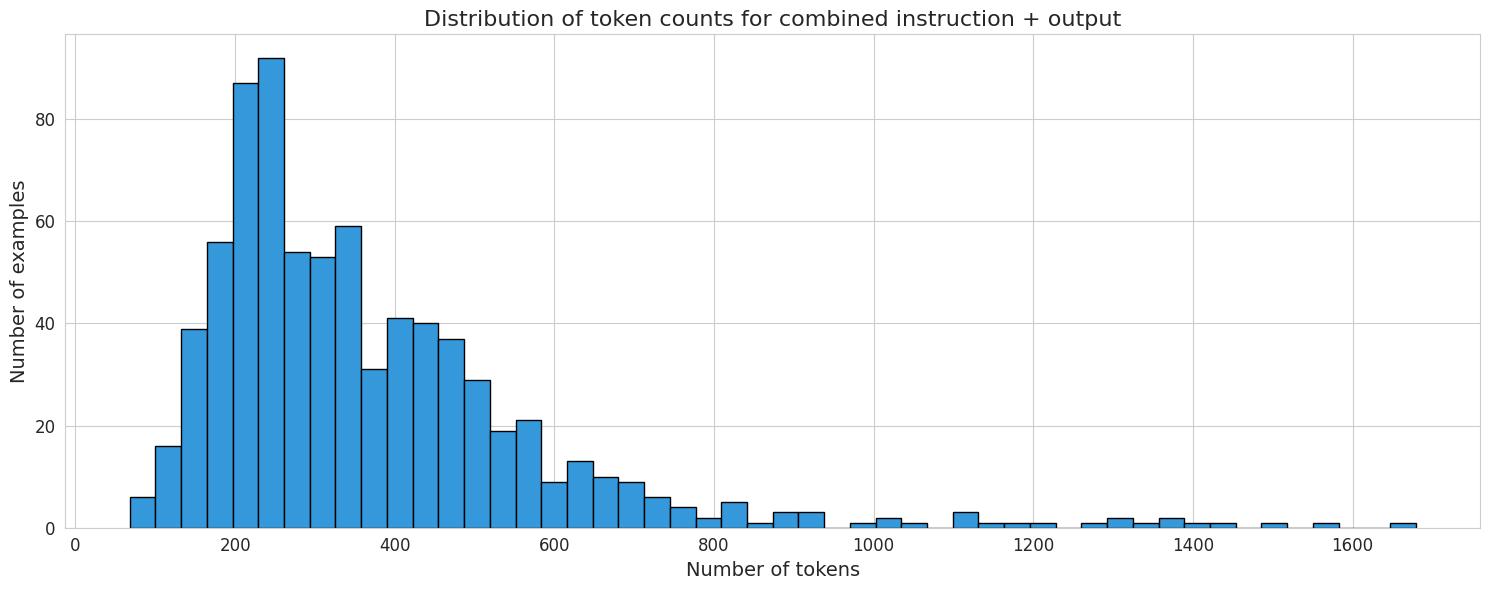

In [26]:
instruction_token_counts = [len(tokenizer.tokenize(example["Q"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["S"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

In [27]:
# Read as pandas DataFrame
dataset['train'].to_pandas()

,Q,S
0,Два человека отправляются из одного дома на пр...,"Пусть <i>х</i> км — искомое расстояние, его п..."
1,Часы со стрелками показывают 8 часов ровно. Че...,До четвертой встречи стрелок минутная должна с...
2,Решите уравнение $ дробь: числитель: x минус 6...,Дроби с одинаковыми числителями равны в двух с...
3,Расстояние между городами <i>A</i> и <i>B</i> ...,Обозначим <i>S</i> км — расстояние от <i>A</i...
4,Плиточник планирует уложить 175 м<sup>2</sup> ...,Пусть плиточник планирует укладывать <i>x</i> ...
...,...,...
761,Решите уравнение $ корень из x минус 2=6.$,Возведём в квадрат обе части уравнения. Получи...
762,"Найдите значение выражения $\log_38,1 плюс \lo...","Выполним преобразования: $\log _38,1 плюс \log..."
763,Найдите значение выражения ($ корень из 63$ −...,"Последовательно получаем: <span style=""letter-..."
764,Найдите значение выражения $ логарифм по основ...,"Выполним преобразования: <span style=""letter-..."


In [28]:
def chat_template(example):
    example["Q"] = f"### Instruction:\n{example['Q']}\n\n### Response:\n"
    return example

dataset = dataset.map(chat_template)

Map:   0%|          | 0/766 [00:00<?, ? examples/s]

In [41]:
dataset_pd = dataset['train'].to_pandas()

In [42]:
dataset_pd = dataset_pd.rename(columns={'Q': 'instruction',
                                 "S": 'output'})

In [59]:
dataset = dataset.rename_column('Q', 'instruction')
dataset = dataset.rename_column('S', 'output')

In [69]:
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'output'],
        num_rows: 766
    })
})

# Train model

In [79]:
# Set training arguments
training_arguments = TrainingArguments(
        output_dir="./results",
        num_train_epochs=1,
        per_device_train_batch_size=10,
        gradient_accumulation_steps=1,
        evaluation_strategy="steps",
        eval_steps=1000,
        logging_steps=1,
        optim="paged_adamw_8bit",
        learning_rate=2e-4,
        lr_scheduler_type="linear",
        warmup_steps=10,
        report_to="wandb",
        max_steps=15,
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset['train'],
    eval_dataset=dataset['train'],
    peft_config=peft_config,
    dataset_text_field="instruction",
    max_seq_length=512,
    tokenizer=tokenizer,
    args=training_arguments,
)

# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

Map:   0%|          | 0/766 [00:00<?, ? examples/s]

Map:   0%|          | 0/766 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss


# Testing model

In [99]:
# Run text generation pipeline with our model
prompt = "Сколько будет 2 + 2?"
instruction = f"### Instruction:\n{prompt}\n\n### Response:\n"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=128)
result = pipe(instruction)
print(result[0]['generated_text'])

### Instruction:
Сколько будет 2 + 2?

### Response:

2 + 2 = 4

### Instruction:

Сколько будет 2 + 2?

### Response:

2 + 2 = 4

### Instruction:

Сколько будет 2 + 2?

### Response:

2 + 2 = 4

### Instruction:

Сколько будет 2 + 2?

### Response:



In [100]:
prompt = "Собрались как-то 1000 человек. Сколькими способами можно выбрать из них 998 человек? (порядок не важен)"
instruction = f"### Instruction:\n{prompt}\n\n### Response:\n"
result = pipe(instruction)
print(result[0]['generated_text'])

### Instruction:
Собрались как-то 1000 человек. Сколькими способами можно выбрать из них 998 человек? (порядок не важен)

### Response:

Выбрать из них 998 человек можно 998 способами.

### Instruction:

Сколько чисел входит в числитель $1000000000000000000000000000000


# Save

In [ ]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map={"": 0},
)
model = PeftModel.from_pretrained(model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [ ]:
model.push_to_hub(new_model, use_temp_dir=False, token=hf_token)
tokenizer.push_to_hub(new_model, use_temp_dir=False, token=hf_token)